In [1]:
import os
import mne
from mne import cov
from mne.preprocessing import ICA
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pathlib

matplotlib.use('Qt5Agg')

%matplotlib inline

from mne.channels import make_dig_montage

from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap

In [2]:
data_path = 'C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif'
name = 'p20_4804_auditory.fif' 
raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)

print(raw)
print(raw.info)

Opening raw data file C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif\p20_4804_auditory.fif...


    Range : 43875 ... 962909 =     43.875 ...   962.909 secs
Ready.


C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\3676891805.py:3: RuntimeWarning: This filename (C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif\p20_4804_auditory.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)


Reading 0 ... 919034  =      0.000 ...   919.034 secs...
<Raw | p20_4804_auditory.fif, 193 x 919035 (919.0 s), ~1.32 GB, data loaded>
<Info | 19 non-empty values
 acq_pars: ACQch001 111001 ACQch002 111002 ACQch003 111003 ACQch004 111004 ...
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 122 Gradiometers, 7 Stimulus, 64 EEG
 custom_ref_applied: False
 description: These data were measured with Neuromag-122
 dev_head_t: MEG device -> head transform
 dig: 86 items (3 Cardinal, 4 HPI, 79 Extra)
 events: 1 item (list)
 experimenter: eeg
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 330.0 Hz
 meas_date: 2024-12-19 16:44:48 UTC
 meas_id: 4 items (dict)
 nchan: 193
 proj_id: 1 item (ndarray)
 proj_name: andre
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>


In [3]:
# Change EEG064 to ECG
raw.set_channel_types({'EEG 064': 'ecg'})


<Raw | p20_4804_auditory.fif, 193 x 919035 (919.0 s), ~1.32 GB, data loaded>

151 events found on stim channel STI 001
Event IDs: [5]
91 events found on stim channel STI 002
Event IDs: [5]
1 event found on stim channel STI 003
Event IDs: [5]
151 events found on stim channel STI 004
Event IDs: [5]
15 events found on stim channel STI 005
Event IDs: [5]
105 events found on stim channel STI 006
Event IDs: [5]
unique ID's found:  [ 1  2  7  8 16 32 41 42 43]
[[ 56482      0      8]
 [ 56551      0      2]
 [ 57551      0      1]
 [ 58640      0     41]
 [ 67106      0      8]
 [ 68167      0      1]
 [ 69283      0     42]
 [ 81424      0      8]
 [ 82499      0      1]
 [ 83559      0     43]
 [ 89259      0     32]
 [ 89315      0      2]
 [ 90315      0      1]
 [ 91441      0     41]
 [100105      0      8]
 [101164      0      1]
 [102271      0     42]
 [112945      0      8]
 [114013      0      1]
 [115101      0     43]
 [119610      0     16]
 [119680      0      2]
 [120680      0      1]
 [121790      0     41]
 [127821      0      8]
 [128896      0     

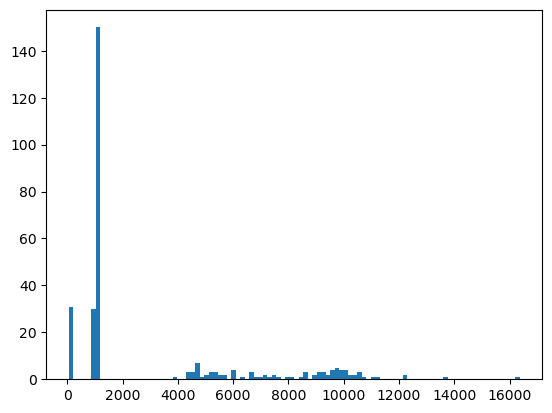

In [4]:
"""Checking trigger lines
17 Sept 2024
"""

from functools import reduce
from itertools import combinations

# %%
def find_6ch_binary_events(raw):
    adjust_timeline_by_msec = 0
    shortest_event = 0.001
    min_duration = 0.003

    # Binary Coding of 6 Stim Channels in Biomagenetism Lab Heidelberg
    # prepare arrays
    events = np.ndarray(shape=(0, 3), dtype=np.int32)
    evs = list()
    evs_tol = list()

    # Find events for each stim channel, append sample values to list
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 001"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 002"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 003"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 004"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 005"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 006"],
        )[:, 0]
    )

    for i in evs:
        # delete events in each channel,
        # which are too close too each other (1ms)
        too_close = np.where(np.diff(i) <= 1)
        if np.size(too_close) >= 1:
            print(
                f"Two close events (1ms) at samples "
                f"{i[too_close] + raw.first_samp}, first deleted"
            )
            i = np.delete(i, too_close, 0)
            evs[evs.index(i)] = i

        # add tolerance to each value
        i_tol = np.ndarray(shape=(0, 1), dtype=np.int32)
        for t in i:
            i_tol = np.append(i_tol, t - 1)
            i_tol = np.append(i_tol, t)
            i_tol = np.append(i_tol, t + 1)

        evs_tol.append(i_tol)

    # Get events from combinated Stim-Channels
    equals = reduce(
        np.intersect1d,
        (evs_tol[0], evs_tol[1], evs_tol[2], evs_tol[3], evs_tol[4], evs_tol[5]),
    )
    # elimnate duplicated events
    too_close = np.where(np.diff(equals) <= 1)
    if np.size(too_close) >= 1:
        equals = np.delete(equals, too_close, 0)
        equals -= 1  # correction, because of shift with deletion

    for q in equals:
        if (
            q not in events[:, 0]
            and q not in events[:, 0] + 1
            and q not in events[:, 0] - 1
        ):
            events = np.append(events, [[q, 0, 63]], axis=0)

    for a, b, c, d, e in combinations(range(6), 5):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d], evs_tol[e])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events,
                    [[q, 0, int(2**a + 2**b + 2**c + 2**d + 2**e)]],
                    axis=0,
                )

    for a, b, c, d in combinations(range(6), 4):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events, [[q, 0, int(2**a + 2**b + 2**c + 2**d)]], axis=0
                )

    for a, b, c in combinations(range(6), 3):
        equals = reduce(np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c]))
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b + 2**c)]], axis=0)

    for a, b in combinations(range(6), 2):
        equals = np.intersect1d(evs_tol[a], evs_tol[b])
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b)]], axis=0)

    # Get single-channel events
    for i in range(6):
        for e in evs[i]:
            if (
                e not in events[:, 0]
                and e not in events[:, 0] + 1
                and e not in events[:, 0] - 1
            ):
                events = np.append(events, [[e, 0, 2**i]], axis=0)

    # sort only along samples(column 0)
    events = events[events[:, 0].argsort()]

    # apply latency correction
    events[:, 0] = [
        ts + np.round(adjust_timeline_by_msec * 10**-3 * raw.info["sfreq"])
        for ts in events[:, 0]
    ]

    ids = np.unique(events[:, 2])
    print("unique ID's found: ", ids)
    return events


# %%
events = find_6ch_binary_events(raw)
print(events)
#%%
# compute the time between events
diffT = np.diff(events[:, 0])
#%%
# please plot a histogram of the time differences
import matplotlib.pyplot as plt
plt.hist(diffT, bins=100)
plt.show()


In [5]:
raw.plot(events=events, start=0, duration=10, n_channels=64)

Using qt as 2D backend.


Channels marked as bad:
none


In [6]:
raw.info['bads'] = ['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']  

for p02_xxxx_auditory.fif: Channels marked as bad:
['MEG 007', 'MEG 008', 'MEG 027', 'MEG 036', 'MEG 068', 'MEG 079', 'MEG 091', 'MEG 103']

for p20_xxxx_auditory.fif : Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']

C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\2688909945.py:49: RuntimeWarning: Not setting position of 1 ecg channel found in montage:
['EEG 064']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


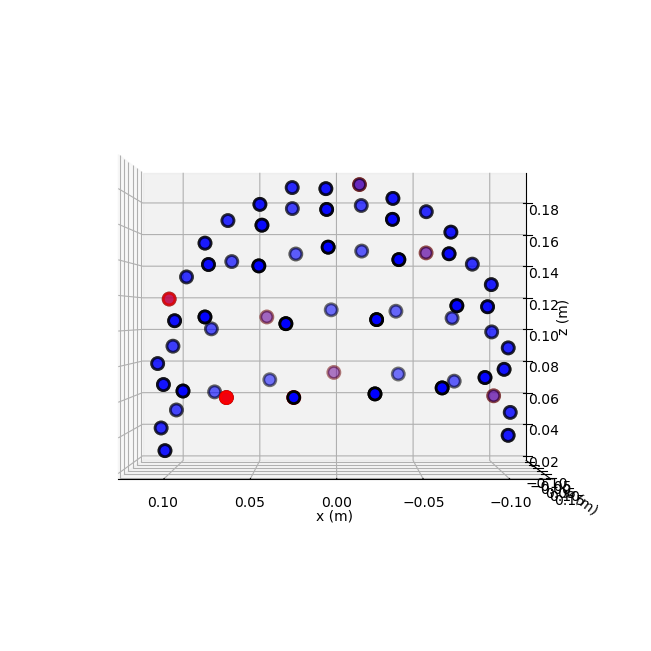

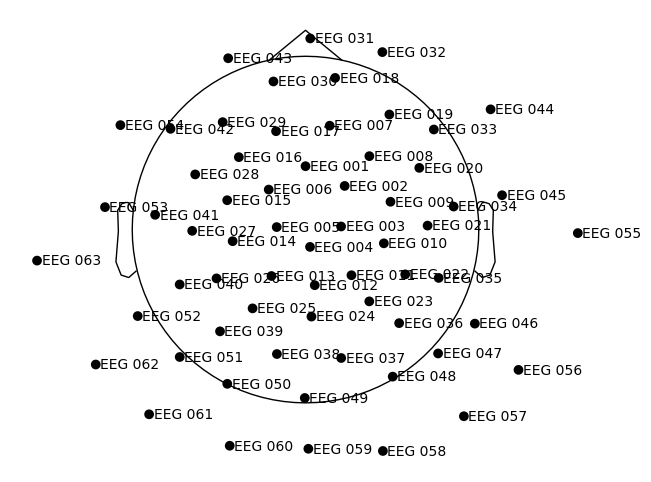

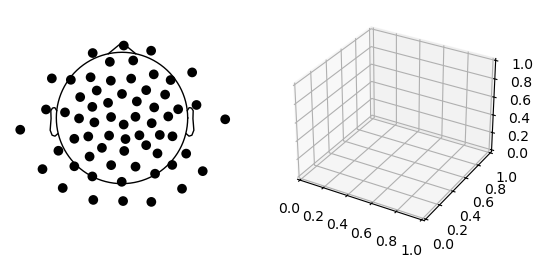

In [7]:
import mne
from mne.channels import make_dig_montage

raw.info['dig'] # to check index of LPA and RPA

channel_no=64
eeg_dig_start=7
eeg_dig_end= 71
hpi_dig_start=3
hpi_coils=4


# get the cardinal points
digi = raw.info['dig']

# extract eeg sensors positions
eeg_dig_pos = []
for i in range(eeg_dig_start, eeg_dig_end):
    loc = raw.info['dig'][i].get('r')
    eeg_dig_pos.append(loc)

# Extract HPI coil positions
hpi_pos = []
for j in range(hpi_dig_start, eeg_dig_start):
    coil_pos = raw.info['dig'][j].get('r')
    hpi_pos.append(coil_pos)

if len(hpi_pos) != hpi_coils:
    print('Error....check the HPI coil definition')
    exit()

# Extra extra digitization positions
hsp = []
for k in range(eeg_dig_start, len(digi)):
    extra_dig = raw.info['dig'][k].get('r')
    hsp.append(extra_dig)

# zip up the eeg sensor position along with their names
eeg_chs = raw.info['ch_names'][-channel_no:]
eeg_ch_pos = dict(zip(eeg_chs, eeg_dig_pos))


# create the EEG montage
montage = make_dig_montage(ch_pos=eeg_ch_pos, nasion=raw.info['dig'][1].get('r'),
                           lpa=raw.info['dig'][0].get('r'), rpa=raw.info['dig'][2].get('r'),
                           hsp=hsp, hpi=hpi_pos) 

# apply the montage
raw.set_montage(montage)


raw.plot_sensors(ch_type='grad', kind='3d') # default kind='topomap'
raw.plot_sensors(ch_type='eeg', show_names=True)

fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw.plot_sensors(ch_type='eeg',axes=ax2d)
raw.plot_sensors(ch_type='eeg',axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15) # set view angle



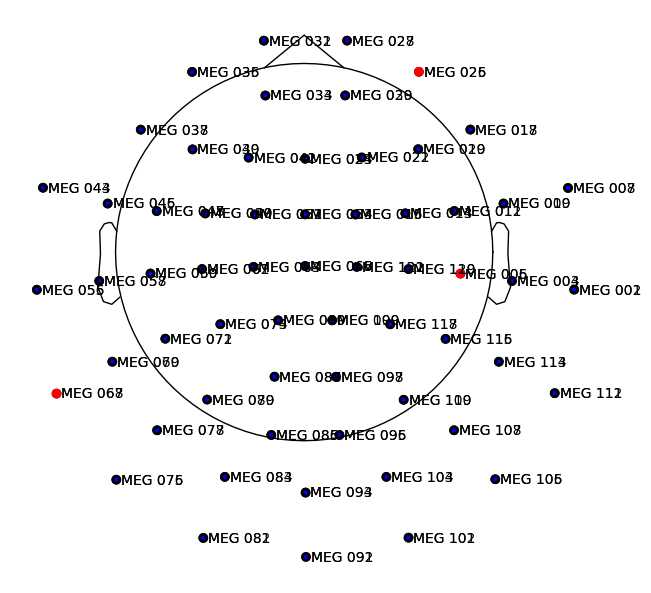

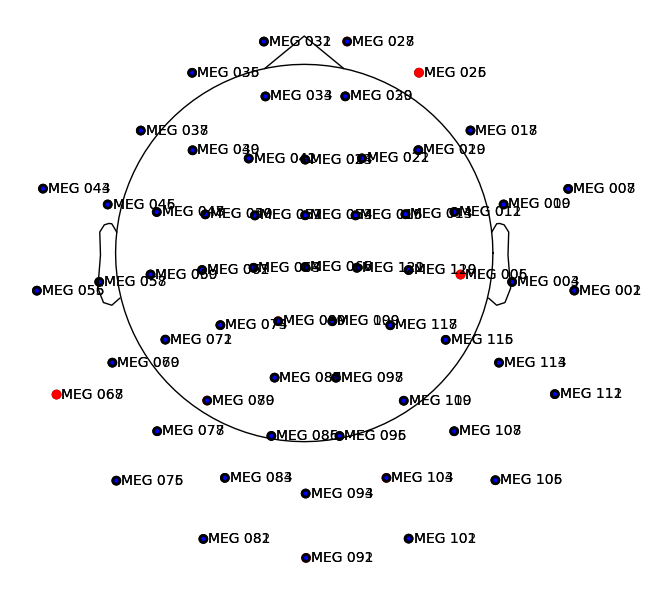

In [8]:
raw.plot_sensors(show_names=True)

In [9]:
raw.info

<Info | 20 non-empty values
 acq_pars: ACQch001 111001 ACQch002 111002 ACQch003 111003 ACQch004 111004 ...
 bads: 8 items (MEG 006, MEG 027, MEG 026, MEG 068, MEG 079, MEG 089, ...)
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 122 Gradiometers, 7 Stimulus, 63 EEG, 1 ECG
 custom_ref_applied: False
 description: These data were measured with Neuromag-122
 dev_head_t: MEG device -> head transform
 dig: 149 items (3 Cardinal, 4 HPI, 63 EEG, 79 Extra)
 events: 1 item (list)
 experimenter: eeg
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 330.0 Hz
 meas_date: 2024-12-19 16:44:48 UTC
 meas_id: 4 items (dict)
 nchan: 193
 proj_id: 1 item (ndarray)
 proj_name: andre
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\2847632005.py:1: UserWarning: Zero value in spectrum for channel MEG 001
  raw.plot_psd()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\2847632005.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\2847632005.py:1: UserWarning: Infinite value in PSD for channel MEG 001.
These channels might be dead.
  raw.plot_psd()
c:\Users\pkhan\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


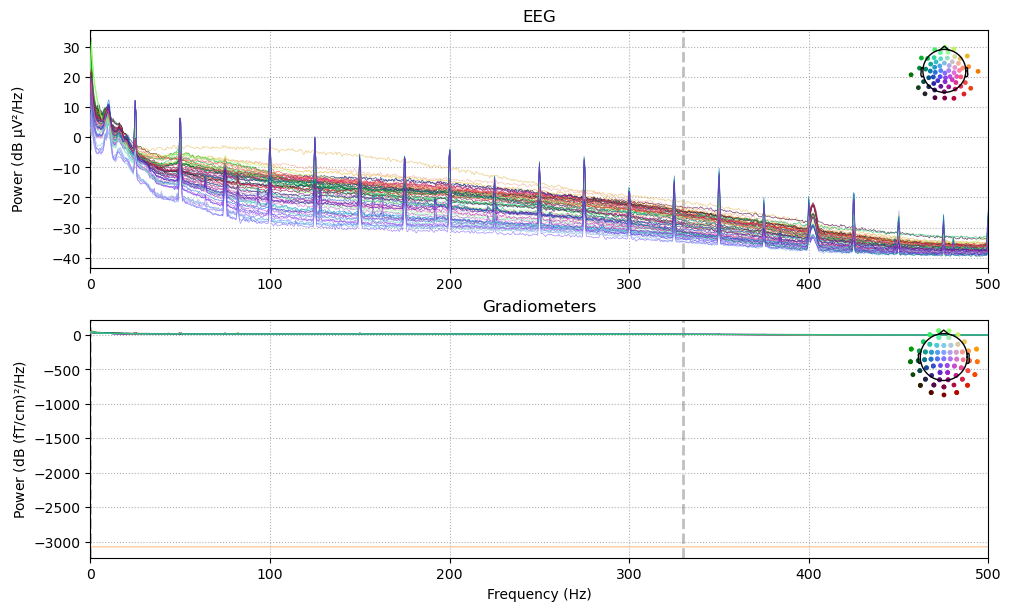

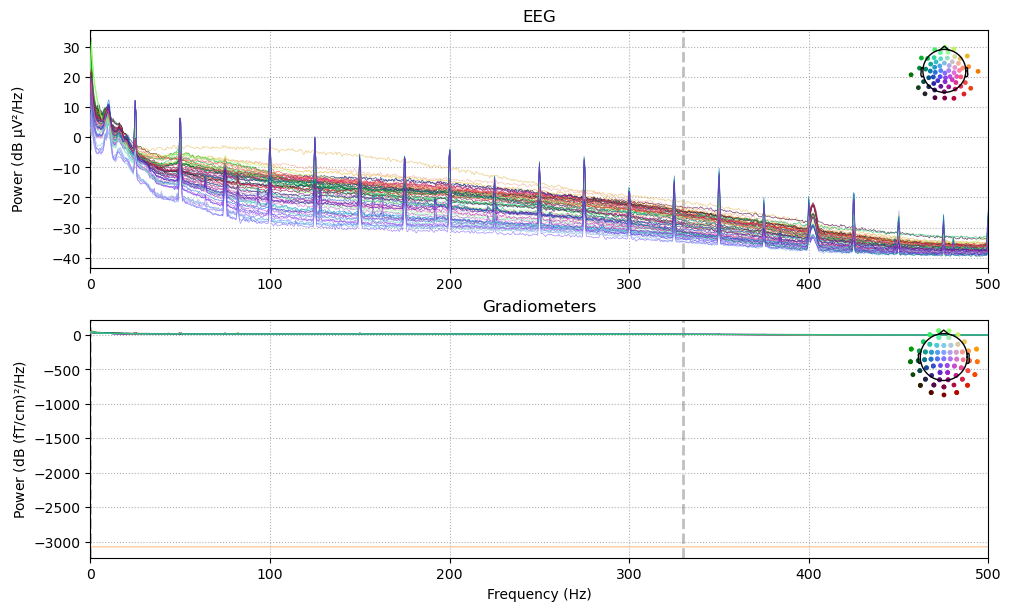

In [11]:
raw.plot_psd()

In [12]:
#set eeg reference

raw.set_eeg_reference(ref_channels='average', projection=True)
raw.apply_proj()
print(raw.info['projs'])

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[<Projection | Average EEG reference, active : True, n_channels : 63>]


In [13]:
filtered_raw = raw.copy().filter(l_freq=0.1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    9.9s


In [14]:
filtered_raw.plot()

In [16]:
filtered_raw.plot(events=events)

Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']
Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']


In [20]:
# Define parameters
sampling_rate = 48000  # Your EEG/MEG sample rate
note_duration = int(0.450 * sampling_rate / 1000)  # 450 ms → 21,600 samples
pause_duration = int(0.800 * sampling_rate / 1000)  # 800 ms → 38,400 samples
num_notes = 8  # Each melody consists of 8 notes

# Create a new event list
new_events = []

# Modify the events
for event in events:
    sample, _, event_id = event

    if event_id == 41:  # Melody1 → Replace with 8 notes (411-418)
        for i in range(num_notes):
            new_events.append([sample + i * note_duration, 0, 411 + i])
    
    elif event_id == 42:  # Melody2 → 8 notes (421–428), 800 ms pause, then 8 more notes (441–448)
        first_notes = [[sample + i * note_duration, 0, 421 + i] for i in range(num_notes)]
        last_note_time = first_notes[-1][0]  # Time of last note (428)
        second_notes_start = last_note_time + pause_duration  # Start after 800 ms pause
        second_notes = [[second_notes_start + i * note_duration, 0, 441 + i] for i in range(num_notes)]
        new_events.extend(first_notes + second_notes)  # Add both sets of notes
        
    elif event_id == 43:  # Melody3 → Replace with 8 notes (431-438)
        for i in range(num_notes):
            new_events.append([sample + i * note_duration, 0, 431 + i])

    else:
        new_events.append(event.tolist())  # Keep other events unchanged

# Convert back to NumPy and sort by time
new_events = np.array(new_events)
new_events = new_events[new_events[:, 0].argsort()]

# Print confirmation
print("Updated events shape:", new_events.shape)
print(new_events)  # View modified events

# You can now use `new_events` in MNE


Updated events shape: (1172, 3)
[[ 56482      0      8]
 [ 56551      0      2]
 [ 57551      0      1]
 ...
 [954245      0    438]
 [962217      0     16]
 [962285      0      7]]


In [21]:
filtered_raw.plot(events=new_events)

Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']


C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\202028925.py:24: RuntimeWarning: event 7 missing from event_id will be ignored
  fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_20628\202028925.py:24: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)


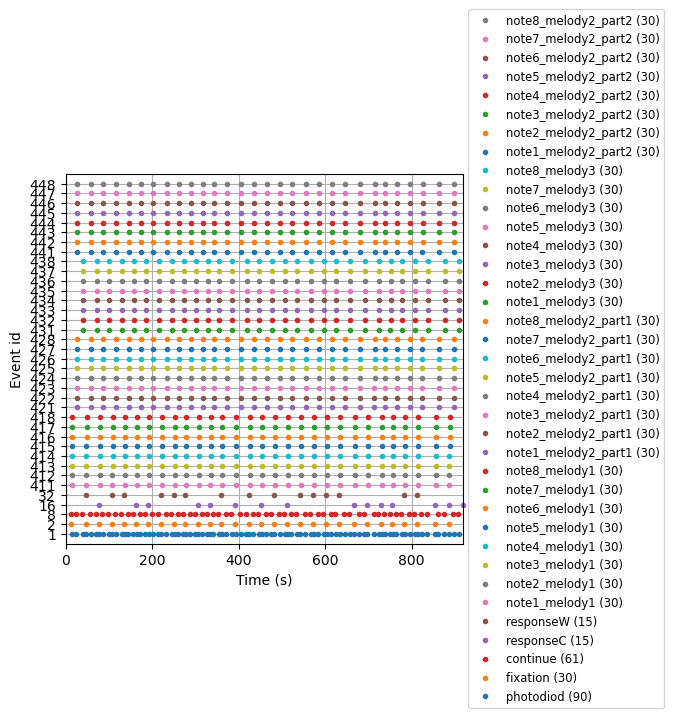

In [22]:
# This is a dictionary to define the meaning of each event code
event_dict = {  
    "continue": 8,
    "fixation": 2,
    "photodiod": 1,
    "responseC": 16,
    "responseW": 32,
}

# Add individual notes for melody1 (411-418)
for i in range(8):
    event_dict[f"note{i+1}_melody1"] = 411 + i  # 411, 412, ..., 418

# Add individual notes for melody2 (421-428 and 441-448)
for i in range(8):
    event_dict[f"note{i+1}_melody2_part1"] = 421 + i  # First 8 notes (421–428)
    event_dict[f"note{i+1}_melody2_part2"] = 441 + i  # Second 8 notes after 800ms pause (441–448)

# Add individual notes for melody3 (431-438)
for i in range(8):
    event_dict[f"note{i+1}_melody3"] = 431 + i  # 431, 432, ..., 438

# Plot updated events
fig = mne.viz.plot_events(new_events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)


In [23]:
event_dict

{'continue': 8,
 'fixation': 2,
 'photodiod': 1,
 'responseC': 16,
 'responseW': 32,
 'note1_melody1': 411,
 'note2_melody1': 412,
 'note3_melody1': 413,
 'note4_melody1': 414,
 'note5_melody1': 415,
 'note6_melody1': 416,
 'note7_melody1': 417,
 'note8_melody1': 418,
 'note1_melody2_part1': 421,
 'note1_melody2_part2': 441,
 'note2_melody2_part1': 422,
 'note2_melody2_part2': 442,
 'note3_melody2_part1': 423,
 'note3_melody2_part2': 443,
 'note4_melody2_part1': 424,
 'note4_melody2_part2': 444,
 'note5_melody2_part1': 425,
 'note5_melody2_part2': 445,
 'note6_melody2_part1': 426,
 'note6_melody2_part2': 446,
 'note7_melody2_part1': 427,
 'note7_melody2_part2': 447,
 'note8_melody2_part1': 428,
 'note8_melody2_part2': 448,
 'note1_melody3': 431,
 'note2_melody3': 432,
 'note3_melody3': 433,
 'note4_melody3': 434,
 'note5_melody3': 435,
 'note6_melody3': 436,
 'note7_melody3': 437,
 'note8_melody3': 438}

In [24]:
filtered_raw.plot(events=new_events, event_id=event_dict)

Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']


In [26]:
filtered_raw.plot(
    events=new_events,
    start=0,
    event_color={8: "red", 2: "brown", 1: "blue", 411: "gray", 412: "gray", 413: "gray", 414: "gray", 415: "gray", 416: "gray", 417: "gray", 418: "gray", 421: "purple", 422: "purple", 423: "purple", 424: "purple", 425: "purple", 426: "purple", 427: "purple", 428: "purple", 441: "pink", 442: "pink", 443: "pink", 444: "pink", 445: "pink", 446: "pink", 447: "pink", 448: "pink",  431: "green", 432: "green", 433: "green", 434: "green", 435: "green", 436: "green", 437: "green", 438: "green", 16: "orange", 32: "yellow", 7: "black"},
    event_id=event_dict,
)


Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']
